# Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

[Context](#Co)<br>
[Import packages and data](#0)<br>
    
1. [**Can we predict a country happiness if we know the gdp per capita, life expectancy and other factors values?**](#Fac)<br>
    [Model 1: using all factors as features](#MF1)<br>
    [Model 2: variable selection (correlation matrix, VIF and RSE)](#MF2)<br>
    [Conclusion](#CF)<br>
    
    
2. [**Can we predict a country happiness only with his historical ?**](#Hi)<br>
    [Model 1: using all historical features (from year-1 to year-3)](#MH1)<br>
    [Model 2: using happiness score historical (from year-1 to year-3](#MH2)<br>
    [Conclusion](#CH)<br>


</div>
<hr>

<a name="Co"></a>
# Context

The **World Happiness Report** is a landmark survey of the state of global happiness from 2015 to 2019 according to 6 main factors:
* economic production, 
* social support, 
* life expectancy, freedom, 
* absence of corruption, 
* and generosity

### Purposes of the project
<ins> Data analysis: </ins>
1. Give a clear picture of happiness around the world in 2019
2. Analyse trends in happiness from 2015 to 2019

<ins> Forecasting with Machine Learning</ins>(\*)
1. Can we predict a country happiness if we know the gdp per capita, life expectancy and other factors values?
2. Can we predict a country happiness thanks to its history (happiness+factors)?

To answer these questions, we'll compare different regression models.

(\*) *Although data don't contain related information, the global pandemic may have a tremendous impact on the results*

You can find the whole presentation and information about the data in the **Project Presentation** notebook

### Workflow
* Cleaning
* EDA
* Data Visualization
* Features Engineering
* **Machine Learning**

--------
Machine Learning is the expertise of the different algorithms and their evaluations. In this notebook, we'll forecast happiness using Machine Learning algorithms to answer the following questions:
1. Can we predict a country happiness if we know the gdp per capita, life expectancy and other factors values?
2. Can we predict a country happiness thanks to its history (happiness+factors)?

------------
------------
<a name="0"></a>
# Import packages and data

In [1]:
import pandas as pd
import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

from utils.Modelisation_utils import train_test_metrics, compare_algo

Import data (see Features Engineering notebook)

In [2]:
# import factors datasets
fact_train_set = pd.read_csv('data/fact_train_set.csv', index_col="country")
fact_test_set = pd.read_csv('data/fact_test_set.csv', index_col="country")

# import historic datasets
hist_train_set = pd.read_csv('data/hist_train_set.csv', index_col="country")
hist_test_set = pd.read_csv('data/hist_test_set.csv', index_col="country")

# drop region and year
hist_train_set.drop(columns=['year','region'],inplace=True)
hist_test_set.drop(columns=['year','region'],inplace=True)

# list of factors
l_factors = ['life_expectancy', 'gdp_per_capita', 'social_support', 
             'freedom','generosity', 'corruption_perception'] 

l_happiness_histo = ['happiness_scoreP1', 'happiness_scoreP2', 'happiness_scoreP3']

l_regions = ['Australia and New Zealand', 'Central and Eastern Europe', 'Eastern Asia', 'Latin America and Caribbean',
            'Middle East and Northern Africa', 'North America', 'Southeastern Asia',
            'Southern Asia', 'Sub-Saharan Africa', 'Western Europe']

-------
# About Modelisation


### Algorithms
For convenience and readibility, we created a function `compare algo` that trains, tests and evaluates several regression algorithms to finally compare them according to a selected metrics. 

Algorithms included in the function are:
* A trivial model that will serve as benchmark: In our case we'll use euristic happiness_score(N) = happiness_score(N-1)
* Linear regression
* Polynomial regression (²)
* Random forest (40 models built with grid random parameters - best model is selected according to MSE on test set)

### Metrics:
* **Mean Square Error (MSE)**: measures the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value.

<img src="data/MSE.png"/>

------------
------------
<a name="Fac"></a>
# 1. Can we predict a country happiness if we know the factor values for the same year ?

Thanks to EDA (see notebook), we highlighted some relationships and patterns in data that will help us to estimate the effienciy of the different algorithms:
1. We can expect linear regression to be very effective because we saw that relationship between `happiness` and `gdp_per_capita`, `life_expectancy` and `social_support` was very likely to be linear
2. We highlighlited some threshold patterns (`corruption_perception`, `freedom`) that give us good reasons to assume that random forest can be effective aswell.
3. Since we didn't see any polynomial relationship between `happiness` and factors, we don't expect polynomial regression to give better results than linear regression.

### Train Test sets
Data from 2016 to 2018 will be used to train our models, and 2019 to test it

In [3]:
benchmark_train= fact_train_set["happiness_scoreP1"]
fact_train_set.drop(columns=["year","happiness_scoreP1"],inplace=True)

benchmark_test= fact_test_set["happiness_scoreP1"]
fact_test_set.drop(columns=["year","happiness_scoreP1"],inplace=True)

<a name="MF1"></a>
## Model 1: using all factors as features

In [4]:
l_features = l_factors + l_regions

In [5]:
compare_algo(fact_train_set, fact_test_set, "happiness_score", l_features, benchmark_test)

RF params: 
n_estimators: 363 / max_features: auto / max_depth: 4 / min_samples_split 15


,Test MSE,Train MSE
Benchmark,17.4926,None
Linear Regression,96.005,80.2926
Polynomial (square) Regression,931.77,27.5244
Random Forest,99.3221,54.6784


Including all features for prediction seems to lead to overfitting, especially for polynomial regression and random forest.
Benchmark heuristic is way more efficient now.

-------------
<a name="MF2"></a>
## Model 2: variable selection (correlation matrix, VIF and RSE)

### Correlation matrix

A correlation matrix is a table showing correlation coefficients between sets of variables. Each random variable (Xi) in the table is correlated with each of the other values in the table (Xj). This allows you to see which pairs have the highest correlation.

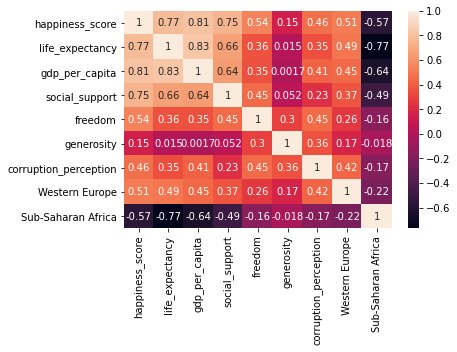

In [6]:
corr_matrix=fact_train_set[["happiness_score"]+l_factors+["Western Europe", "Sub-Saharan Africa"]].corr()

sns.heatmap(corr_matrix, annot = True)

As we can see, `happiness` has strong correlation with `gdp per capita`, `life expectancy` and `social support`

In [7]:
l_features_corr = ['gdp_per_capita', 'life_expectancy', 'social_support']

In [8]:
compare_algo(fact_train_set, fact_test_set, "happiness_score", l_features_corr, benchmark_test)

RF params: 
n_estimators: 104 / max_features: log2 / max_depth: 3 / min_samples_split 5


,Test MSE,Train MSE
Benchmark,17.4926,None
Linear Regression,143.676,124.109
Polynomial (square) Regression,140.502,101.769
Random Forest,115.987,65.3681


While we managed to decrease overfitting because we used a simpler model, accuracy is slighly lower than the model including all features

### VIF

In statistics, the variance inflation factor (VIF) is the quotient of the variance in a model with multiple terms by the variance of a model with one term alone. It quantifies the severity of multicollinearity in an ordinary least squares regression analysis. 

We compute VIF Factor for predictors and remove the one with highest VIF factor (high colinearity) until only predictors with <5 VIF factors are remaining

In [10]:
l_features_vif = l_features

max_VIF = 5

while max_VIF>=5:
    X_train = fact_train_set[l_features_vif].copy()
    vif = pd.DataFrame() #Let us show th VIF scores in a data frame
    vif["Features"] = X_train.columns
    vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])] #variance_inflation_factor calculates the scores #for each Feature
    vif = vif.sort_values(by="VIF Factor", ascending=False).reset_index(drop=True)
    
    max_VIF = vif.iloc[0]["VIF Factor"]
    l_features_vif = [i for i in l_features_vif if i!=vif.iloc[0]["Features"]]

display(vif)
    

,Features,VIF Factor
0,corruption_perception,1.873301
1,Middle East and Northern Africa,1.237359
2,Sub-Saharan Africa,1.143291
3,Australia and New Zealand,1.130814
4,Latin America and Caribbean,1.089508
5,Central and Eastern Europe,1.078196
6,North America,1.063971
7,Southeastern Asia,1.062370
8,Southern Asia,1.047705
9,Eastern Asia,1.020086


In [11]:
compare_algo(fact_train_set, fact_test_set, "happiness_score", l_features_vif, benchmark_test)

RF params: 
n_estimators: 109 / max_features: auto / max_depth: 5 / min_samples_split 20


,Test MSE,Train MSE
Benchmark,17.4926,None
Linear Regression,197.753,195.567
Polynomial (square) Regression,201.606,199.945
Random Forest,306.388,300.717


**Comprendre pourquoi VIF fonctionne pas bien avec les variables boolean**

Thanks to VIF variable selection, we almost removed overfitting, but our model accuracy is even lower than correlation matrix

### RFE

Recursive Feature Elimination, or RFE for short, is a popular feature selection algorithm.

RFE is popular because it is easy to configure and use and because it is effective at selecting those features (columns) in a training dataset that are more or most relevant in predicting the target variable.

In [12]:
from sklearn.feature_selection import RFE

X_train = fact_train_set[l_factors].copy()
y_train = fact_train_set["happiness_score"].copy()

selector = RFE(LinearRegression(), n_features_to_select=4, step=1)
selector = selector.fit(X_train, y_train)

In [13]:
selector_idx = [i for i in range(len(selector.support_)) if selector.support_[i]]
display(selector_idx)

selected_var = [X_train.columns[i] for i in selector_idx]
display(selected_var)

[0, 1, 2, 3]

['life_expectancy', 'gdp_per_capita', 'social_support', 'freedom']

In [14]:
compare_algo(fact_train_set, fact_test_set, "happiness_score", selected_var, benchmark_test)

RF params: 
n_estimators: 92 / max_features: auto / max_depth: 8 / min_samples_split 20


,Test MSE,Train MSE
Benchmark,17.4926,None
Linear Regression,120.3,107.464
Polynomial (square) Regression,104.167,84.9138
Random Forest,107.018,67.8386


With RSE variable selection, accuracy is slightly better than using other methods, but the model is overfitting

-------------
<a name="CF"></a>
## Conclusion

As we saw with our different models, information contained in our data seems not to be enough to predict happiness with accuracy. Even if we almost removed overfitting problem by using variables selection methods, all of our models had a big bias, and our benchmark model based on trivial heuristic *happiness(year)=happiness(year-1)* remains unbeatable.

An option to try to increase accuracy would be to collect more data from the survey or open data

Let's now try to forecast happiness of a country with his past happiness and factors historic

------------
------------
<a name="hi"></a>
# 2. Can we predict a country happiness only with his historical ?

Since we did not study history in our EDA notebook, we don't have a priori knowledge about which algorithms will give us the best results. However, we can expect to beat our heuristic model (*happiness(year)=happiness(year-1)* which is equivalent to use just 1 year of history

We will train algorithms on 2018 data with 3 years history (2015-2017) and evaluate (test) on 2019 (history from 2016 to 2018)

In [15]:
benchmark_test = hist_test_set["happiness_scoreP1"].copy()

<a name="MH1"></a>
## Model 1: using all historical features (from year-1 to year-3)

In [16]:
compare_algo(hist_train_set, hist_test_set, "happiness_score", hist_train_set.drop(columns=["happiness_score"]).columns, 
                                                                                   benchmark_test)

RF params: 
n_estimators: 152 / max_features: auto / max_depth: 3 / min_samples_split 20


,Test MSE,Train MSE
Benchmark,17.4926,None
Linear Regression,32.7187,9.09998
Polynomial (square) Regression,677.141,2.50463e-25
Random Forest,14.6871,4.41207


While our models give way better results than previous ones, they are overfitting (especially polynomial regression) and we are going to try to build simpler models by using only happiness history

-------------
<a name="MH2"></a>
## Model 2: using happiness history (from year-1 to year-3)

In [17]:
l_happiness_historic = ["happiness_scoreP1", "happiness_scoreP2", "happiness_scoreP3"]

compare_algo(hist_train_set, hist_test_set, "happiness_score", l_happiness_historic, benchmark_test)

RF params: 
n_estimators: 175 / max_features: log2 / max_depth: 6 / min_samples_split 5


,Test MSE,Train MSE
Benchmark,17.4926,None
Linear Regression,13.6896,13.0592
Polynomial (square) Regression,16.4443,10.848
Random Forest,27.8134,16.0704


As expected, we finally managed to lower MSE with **Linear regression** ! Furthermore, the small difference between train and test MSE ensures that our model is able to generalize and be applied to new data.

-------------
<a name="CH"></a>
## Conclusion

Ton conclude, it appears that our heuristic model as beaten most of our predictive model. Most of but not all ! Predicting happiness using linear regression as algorithm and happiness historic as predictors gave us predictions with low bias (good accuracy) and low variance (generalization).